**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [202]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [203]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric = 'euclidean', weights = 'uniform'):
        algorithms = {
            'brute' : self.indices_by_brute, 
            'kd_tree' : self.indices_by_KDTree
        }
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.algorithm_reference = algorithms.get(self.algorithm, self.indices_by_brute)
        self.metric = metric
        self.weights = weights
    
    def fit(self, X, y):
        inner_rep = {
            'kd_tree': KDTree,
            'brute' : self.__identity__
        }
        self.X = inner_rep.get(self.algorithm, self.__identity__)(X)
        self.y = y
        self.class_count = np.max(self.y)
    
    def __identity__(self, X):
        return X
    
    def predict(self, X):
        indices = self.algorithm_reference(X)
        return np.argmax(np.apply_along_axis(lambda x: np.bincount(x, minlength=self.class_count + 1), axis=1, arr=self.y[indices]), axis = 1)
    
    def k_nearest_per_row(self, X):
        return np.argpartition(X, self.n_neighbors, axis = 1)[:,:self.n_neighbors:]
    
    def indices_by_brute(self, X):
        return self.k_nearest_per_row(pairwise_distances(X, self.X, metric = self.metric))
    
    def indices_by_KDTree(self, X):
        return self.X.query(X, k = self.n_neighbors)[1]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [204]:
iris = datasets.load_iris()

In [205]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [206]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [207]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [208]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [209]:
%time clf.fit(X_train, y_train)

CPU times: user 542 µs, sys: 0 ns, total: 542 µs
Wall time: 601 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [210]:
%time my_clf.fit(X_train, y_train)

CPU times: user 63 µs, sys: 3 µs, total: 66 µs
Wall time: 68.2 µs


In [211]:
%time clf.predict(X_test)

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 1.6 ms


array([1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1])

In [212]:
%time my_clf.predict(X_test)

CPU times: user 1.29 ms, sys: 3 µs, total: 1.3 ms
Wall time: 1.12 ms


array([1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [213]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [214]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [215]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 1.92 ms, total: 1.92 ms
Wall time: 31.5 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [216]:
%time my_clf.fit(X_train, y_train)

CPU times: user 988 µs, sys: 411 µs, total: 1.4 ms
Wall time: 1.05 ms


In [217]:
%time clf.predict(X_test)

CPU times: user 0 ns, sys: 2.21 ms, total: 2.21 ms
Wall time: 2.29 ms


array([2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 2, 2])

In [218]:
%time my_clf.predict(X_test)

CPU times: user 1.2 ms, sys: 48 µs, total: 1.24 ms
Wall time: 1.17 ms


array([2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 2, 2])

In [219]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [220]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [221]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [222]:
min_freq = 0.005
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(data)
scaler = preprocessing.StandardScaler().fit(X.todense())
X_stand = scaler.transform(X.todense())

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [223]:
kf = KFold(n_splits = 3)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 3772  3773  3774 ... 11311 11312 11313] TEST: [   0    1    2 ... 3769 3770 3771]
TRAIN: [    0     1     2 ... 11311 11312 11313] TEST: [3772 3773 3774 ... 7540 7541 7542]
TRAIN: [   0    1    2 ... 7540 7541 7542] TEST: [ 7543  7544  7545 ... 11311 11312 11313]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [224]:
def choose_neighbor_number(X, y, max_neighbors = 10, fold_number = 3, metric = 'euclidean', knn = MyKNeighborsClassifier, threshold = 10, step = 10):
    def constructRange(max_value, threshold, step):
        if (threshold is None) or (threshold > max_value):
            threshold = max_value
        if step is None:
            step = 10
        range_ = list(range(1, threshold))
        range_ += list(range(threshold, max_value+step, step))
        return range_
    if fold_number < 2:
        fold_number = 2
    neighbor_range = constructRange(max_neighbors, threshold, step)
    kf = StratifiedKFold(n_splits=fold_number)
    accuracy_per_neighbor = []
    for neighbor in neighbor_range:
        my_clf = knn(neighbor, algorithm='brute', metric=metric)
        accuracy_per_fold = cross_val_score(my_clf, X, y, cv = kf.split(X, y), scoring='accuracy')
        accuracy_per_neighbor.append(accuracy_per_fold)
    accuracy_per_neighbor = np.asarray(accuracy_per_neighbor).mean(axis = 1)
    best_neighbor = neighbor_range[np.argmax(accuracy_per_neighbor)]
    return accuracy_per_neighbor, neighbor_range, best_neighbor

In [225]:
result_EC, range_EC, best_neighbor_EC = choose_neighbor_number(X = X_stand, y = target, max_neighbors=100, metric='euclidean', knn = MyKNeighborsClassifier, threshold = 1, step = 10)

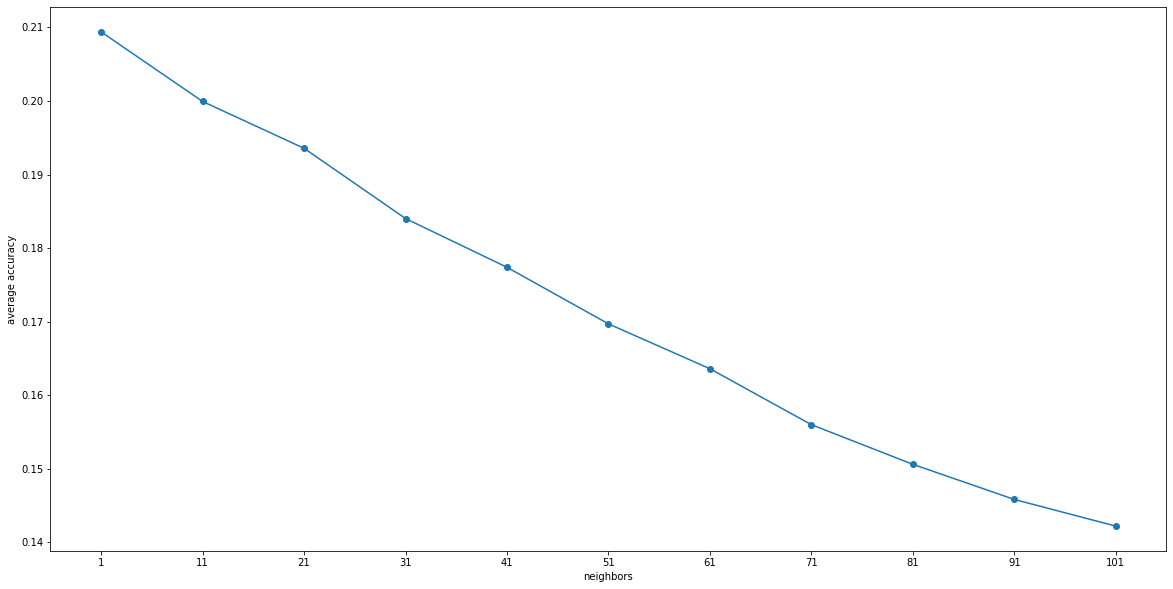

In [226]:
x = range_EC
y = result_EC
plt.figure(figsize=(20,10))
plt.xlabel('neighbors')
plt.ylabel('average accuracy')
plt.xticks(x)
plt.plot(x, y, '-o')
plt.show()

In [227]:
best_cross_val_score_EC = result_EC[range_EC.index(best_neighbor_EC)]
best_cross_val_score_EC

0.20938661956575635

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [228]:
result_CC, range_CC, best_neighbor_CC = choose_neighbor_number(X = X_stand, y = target, max_neighbors=100, metric='cosine', knn = MyKNeighborsClassifier, threshold = 1, step = 10)

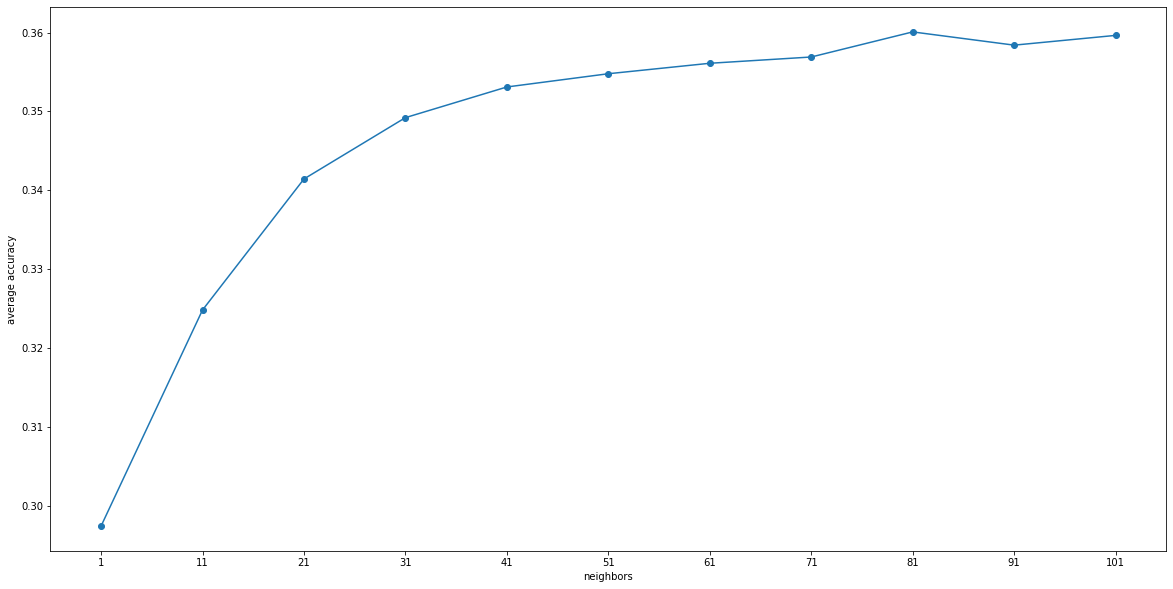

In [229]:
x = range_CC
y = result_CC
plt.figure(figsize=(20,10))
plt.xlabel('neighbors')
plt.ylabel('average accuracy')
plt.xticks(x)
plt.plot(x, y, '-o')
plt.show()

In [230]:
best_cross_val_score_CC = result_CC[range_CC.index(best_neighbor_CC)]
best_cross_val_score_CC

0.36008487968730124

In [231]:
tfidfVectorizer = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X_tfidf = tfidfVectorizer.fit_transform(data)

In [232]:
scaler_tfidf = preprocessing.StandardScaler().fit(X_tfidf.todense())
X_tfidf_stand = scaler_tfidf.transform(X_tfidf.todense())

In [233]:
result_ET, range_ET, best_neighbor_ET = choose_neighbor_number(X = X_tfidf_stand, y = target, max_neighbors=100, metric='euclidean', knn = MyKNeighborsClassifier, threshold=1, step = 10)

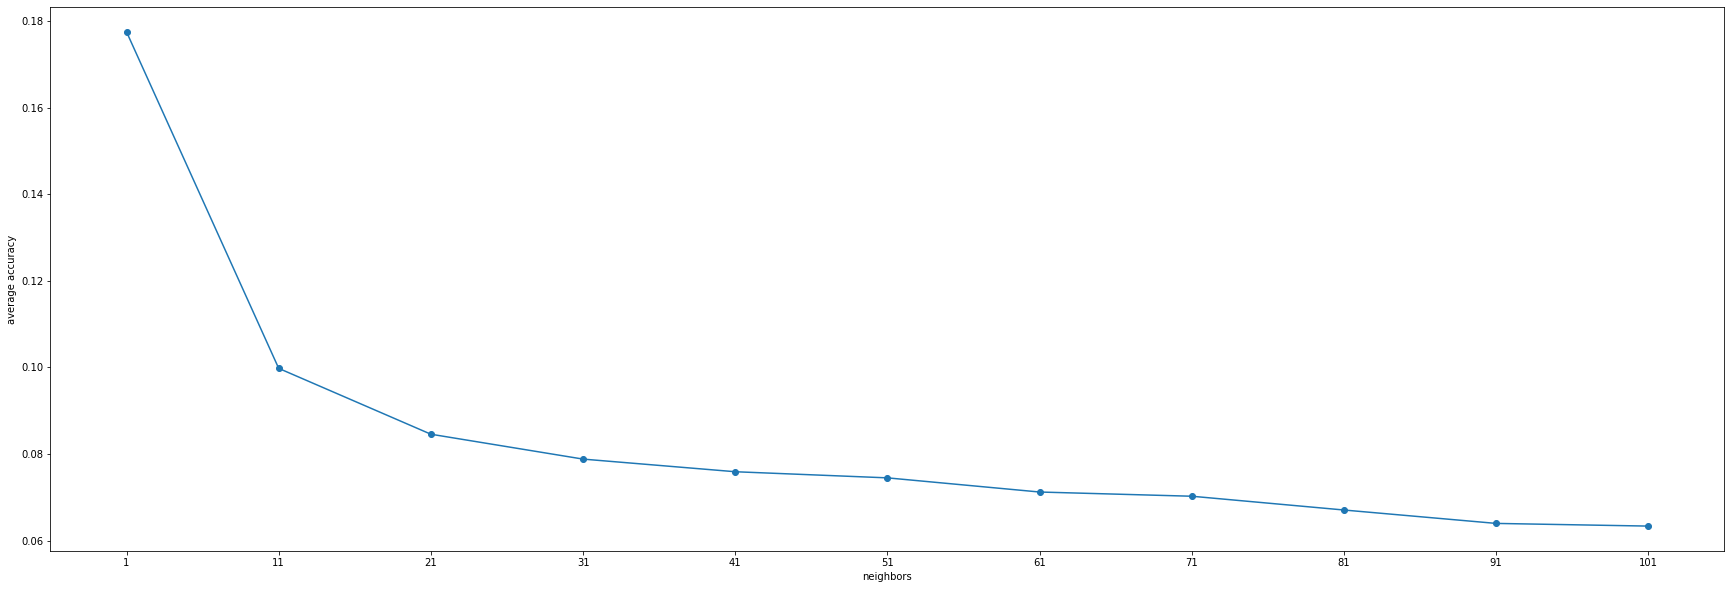

In [234]:
x = range_ET
y = result_ET
plt.figure(figsize=(30,10))
plt.xlabel('neighbors')
plt.ylabel('average accuracy')
plt.xticks(x)
plt.plot(x, y, '-o')
plt.show()

In [235]:
best_cross_val_score_ET = result_ET[range_ET.index(best_neighbor_ET)]
best_cross_val_score_ET

0.17747916955493445

In [236]:
result_CT, range_CT, best_neighbor_CT = choose_neighbor_number(X = X_tfidf_stand, y = target, max_neighbors=100, metric='cosine', knn = MyKNeighborsClassifier, threshold=1, step = 10)

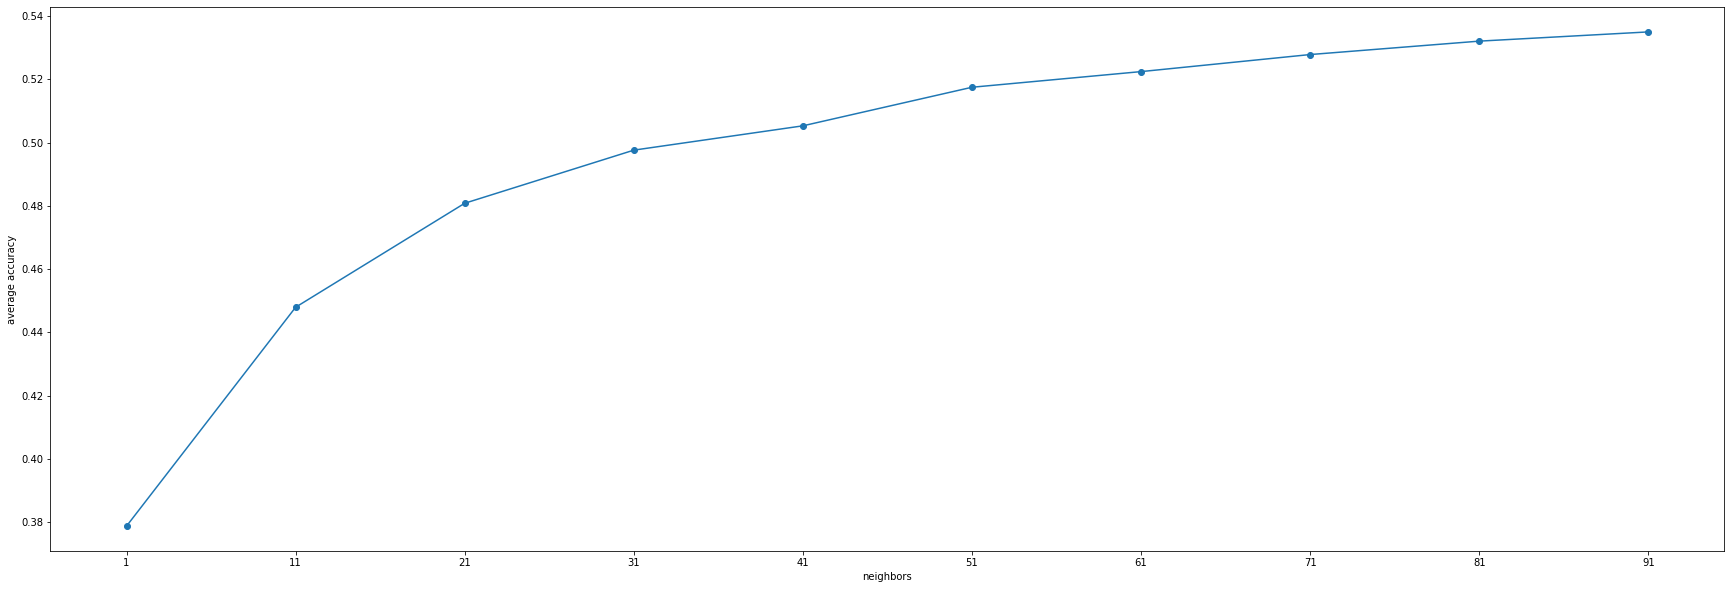

In [237]:
x = range_
y = result
plt.figure(figsize=(30,10))
plt.xlabel('neighbors')
plt.ylabel('average accuracy')
plt.xticks(x)
plt.plot(x, y, '-o')
plt.show()

In [238]:
best_cross_val_score_CT = result_CT[range_CT.index(best_neighbor_CT)]
best_cross_val_score_CT

0.5386250101821691

Лучшая модель: метрика = 'cosine', векторизатор = TfidfVectorizer

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [239]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [240]:
data_test = newsgroups['data']
target_test = newsgroups['target']

vectorizer_test = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, vocabulary=tfidfVectorizer.get_feature_names())
X_test_Tfidf = vectorizer_test.fit_transform(data_test)

In [241]:
scaler_tfidf = preprocessing.StandardScaler().fit(X_tfidf.todense())
X_tfidf_stand = scaler_tfidf.transform(X_tfidf.todense())
X_test_Tfidf_stand = scaler_tfidf.transform(X_test_Tfidf.todense())

In [242]:
neighbor_count = best_neighbor
metrics = 'cosine'

In [243]:
my_clf = MyKNeighborsClassifier(n_neighbors=neighbor_count, algorithm = 'brute', metric=metrics)
my_clf.fit(X_tfidf_stand, target)
my_clf_pred = my_clf.predict(X_test_Tfidf_stand)
test_score = accuracy_score(target_test, my_clf_pred)

In [244]:
score_diff = best_cross_val_score - test_score
score_diff

0.060826968256931124

Score на кросс-валидации лучше, чем на тестовой выборке.
Возможная причина: различия в множествах слов в текстах тренировочной выборки и тестовой выборки, а модель использует только слова из тренировочной выборки. К тому же, модель рассматривает не все слова из тренировочной выборки (max_features, min_df, max_df), иначе признаков становится слишком много и не хватает памяти для вычислений.